In [1]:
import cv2
import commonfunctions
import numpy as np 
import matplotlib.pyplot as plt
import math

In [2]:
def applySift(train_image , test_image):
    train_image = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp1,desc1 = sift.detectAndCompute(train_image,None)
    kp2,desc2 = sift.detectAndCompute(test_image,None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1,desc2,k=2)
    
    #apply test 
    good = [] 

    for m,n in matches:
        if m.distance < 0.6*n.distance:
            good.append([m])

    img3 = cv2.drawMatchesKnn(train_image,kp1,test_image,kp2,good[:150],None,flags=2)
    commonfunctions.show_images([img3])
    return

In [5]:
def find_matching_boxes(image, template, detector_method, params):

    # Parameters and their default values
    MAX_MATCHING_OBJECTS = params.get('max_matching_objects', 10)
    SIFT_DISTANCE_THRESHOLD = params.get('SIFT_distance_threshold', 0.5)
    BEST_MATCHES_POINTS = params.get('best_matches_points', 20)

    # Initialize the detector and matcher
    if detector_method == "SIFT":
        detector = cv2.SIFT_create()
        bf = cv2.BFMatcher()
    elif detector_method == "ORB":
        detector = cv2.ORB_create(fastThreshold=5, edgeThreshold=10)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    else:
        raise ValueError("Unsupported detector method")

    # Find keypoints and descriptors for the template
    keypoints2, descriptors2 = detector.detectAndCompute(template, None)

    matched_boxes = []
    matching_img = image.copy()

    for i in range(MAX_MATCHING_OBJECTS):
        # Match descriptors
        keypoints1, descriptors1 = detector.detectAndCompute(matching_img, None)

        if detector_method == "SIFT":
            # Matching strategy for SIFT
            matches = bf.knnMatch(descriptors1, descriptors2, k=2)
            good_matches = [m for m, n in matches if m.distance < SIFT_DISTANCE_THRESHOLD * n.distance]
            good_matches = sorted(good_matches, key=lambda x: x.distance)[:BEST_MATCHES_POINTS]

        elif detector_method == "ORB":
            # Matching strategy for ORB
            matches = bf.match(descriptors1, descriptors2)
            matches = sorted(matches, key=lambda x: x.distance)
            good_matches = matches[:BEST_MATCHES_POINTS]
        
        else:
            raise ValueError("Unsupported detector method")

        # Extract location of good matches
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

        # Find homography for drawing the bounding box
        try:
            H, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 2)
        except cv2.error:
            print("No more matching box")
            break

        # Transform the corners of the template to the matching points in the image
        h, w = template.shape[:2]
        corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners, H)
        matched_boxes.append(transformed_corners)

        # You can uncomment the following lines to see the matching process
        # Draw the bounding box
        img1_with_box = matching_img.copy()
        matching_result = cv2.drawMatches(img1_with_box, keypoints1, template, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        cv2.polylines(matching_result, [np.int32(transformed_corners)], True, (255, 0, 0), 3, cv2.LINE_AA)
        plt.imshow(matching_result, cmap='gray')
        plt.show()

        # Create a mask and fill the matched area with near neighbors
        matching_img2 = cv2.cvtColor(matching_img, cv2.COLOR_BGR2GRAY) 
        mask = np.ones_like(matching_img2) * 255
        cv2.fillPoly(mask, [np.int32(transformed_corners)], 0)
        mask = cv2.bitwise_not(mask)
        matching_img = cv2.inpaint(matching_img, mask, 3, cv2.INPAINT_TELEA)

    return matched_boxes



In [7]:
pen_cluttered = cv2.imread('./results/32.jpg') # Template
pen_cluttered = cv2.cvtColor(pen_cluttered, cv2.COLOR_BGR2RGB)

#commonfunctions.show_images([pen_cluttered])

pen_copybook = cv2.imread('./test_images/input6.jpg') # Image 
pen_copybook = cv2.cvtColor(pen_copybook, cv2.COLOR_BGR2RGB)

#commonfunctions.show_images([pen_copybook])



No more matching box


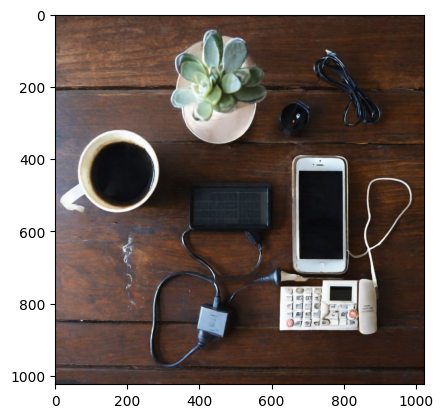

In [8]:
params = {
    'max_matching_objects': 5,
    'SIFT_distance_threshold': 0.5,
    'best_matches_points': 20
}

matched_boxes = find_matching_boxes(pen_copybook, pen_cluttered , "SIFT", params) 

# Draw the bounding boxes on the original image
for box in matched_boxes:
    cv2.polylines(pen_copybook, [np.int32(box)], True, (0, 255, 0), 3, cv2.LINE_AA)

plt.imshow(pen_copybook)
plt.show()

## Another Test

76.59634399414062 134.1379852294922
289.4443054199219 498.1987609863281
278.4133605957031 489.8999938964844
306.20745849609375 479.3975524902344
328.9483337402344 501.6911315917969
295.7330017089844 474.573486328125
200.53428649902344 490.3386535644531
283.06005859375 432.1180419921875
59.62382125854492 128.95347595214844
20.29778289794922 133.3716583251953
19.209373474121094 73.32803344726562
48.88762664794922 81.3879623413086
33.778690338134766 90.87904357910156
27.766887664794922 167.4305877685547
4.242640495300293 95.84362030029297
12.845232963562012 124.04031372070312
340.45703125 493.951416015625
4.358899116516113 83.23461151123047
3.1622776985168457 94.76286315917969
364.05767822265625 523.2379760742188
34.510868072509766 71.0633544921875
360.45526123046875 522.643310546875
2.8284270763397217 117.27745056152344
330.411865234375 514.8436889648438
7.8102498054504395 198.3406219482422
84.56949615478516 515.1290893554688
7.681145668029785 397.183837890625
21.470911026000977 468.6011

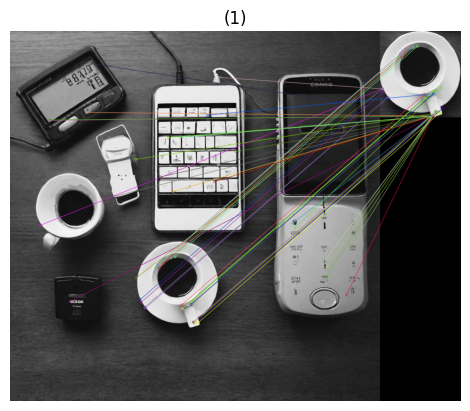

In [26]:
#applysift
applySift(pen_copybook,pen_cluttered)